In [1]:
# Import libraries

import torch
from torchfem import Planar
from torchfem.materials import IsotropicPlaneStress
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.double)

In [2]:
# Inputs

# Define material properties for the wheel
# Aluminum alloy LM25
E = 71000.0
nu = 0.33
material = IsotropicPlaneStress(E = E, nu = nu)

# Considered sector of the wheel
n = 7.0 # Not needed in considered cases, however, can be used when position of the segment matters, e.g., force is always pointing downwards

# Restricted domain of the circle
inner_rim_radius = 0.2

# Set up parameters
volume_constraint = 0.4
penalization_factor = 3.0
filter_radius = 0.03

# Thickness
d = 0.5

# Values for weight and breaking forces calculation
mass_per_wheel_sector = 25.0  # kg, 1 tonn car, 4 wheels, 250 kg per wheel, 1/10th of a wheel considered
acceleration_of_gravity = 9.8  # m/s^2
coefficient_of_friction = 0.8 # New tires, 72 km/h or 20 m/s

In [3]:
# Functions

# Bisection
def bisection(f, a, b, max_iter=50, tol=1e-10):
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

# Compute areas
def compute_areas(item):
    areas = torch.zeros((item.n_elem))
    nodes = item.nodes[item.elements, :]
    for w, q in zip(item.etype.iweights(), item.etype.ipoints()):
        J = item.etype.B(q) @ nodes
        detJ = torch.linalg.det(J)
        areas += w * detJ
    return areas

# Optimize
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=penalization_factor, r=filter_radius):
    k0 = torch.einsum("i,ijk->ijk", 1.0 / fem.thickness, fem.k())
    rho = [rho_0.clone()]  # Clone to avoid modifying the original rho_0
    vols = d * compute_areas(fem)
    compliance = []

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        ecenters = torch.stack([torch.mean(fem.nodes[e], dim=0) for e in fem.elements])
        dist = torch.cdist(ecenters, ecenters)
        H = r - dist
        H[dist > r] = 0.0

    # Iterate solutions
    for k in tqdm(range(iter)):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        compliances = (f_k * u_k).sum().item()
        compliance.append(compliances)

        # Compute sensitivities
        disp = u_k[fem.elements, :].reshape(fem.n_elem, -1)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)
        sensitivity = -p * 0.1 * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.clamp(rho_trial, lower, upper)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu) ensuring it accurately respects the volume constraint
        mu = bisection(g, 1e-10, 100.0)

        # Check volume constraint after step
        rho_new = make_step(mu)
        actual_volume = torch.dot(rho_new, vols)
        
        if actual_volume > V_0 + 1e-6:  # Ensure the volume does not exceed the target
            raise Exception("Volume constraint cannot be achieved")

        # Append new density
        rho.append(rho_new)

    return rho, compliance

# Function to rotate points by a given angle
def rotate(points, angle):
    rotation_matrix = torch.tensor([
        [torch.cos(angle), -torch.sin(angle)],
        [torch.sin(angle), torch.cos(angle)]
    ], dtype=torch.double)
    return points @ rotation_matrix.T

def plot_wheel(wheel, optimized_properties, cmap_name="gray_r"):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap(cmap_name)
    for i in range(10):
        angle = torch.tensor(i * torch.pi / 5)  # 36 degrees rotation for each segment
        rotated_nodes = rotate(wheel.nodes, angle)

        # Get the element property for each element (mapped to a color)
        colors = cmap(optimized_properties.numpy())

        for e, color in zip(wheel.elements, colors):
            polygon = rotated_nodes[e].numpy()
            ax.fill(polygon[:, 0], polygon[:, 1], color=color, edgecolor=color)  # Use edgecolor to avoid gaps

    ax.set_aspect('equal')
    ax.set_axis_off()  # Hide the axes for a cleaner look
    plt.show()

In [4]:
# Create initial setup

# Create nodes for the bottom 1/10th circular domain (36 degrees)
N = 30  # Number of divisions along the radius and angle
radius = torch.linspace(inner_rim_radius, 1.0, N + 1)  # Adjust radial domain to exclude the centre
theta_min = torch.tensor(n * torch.pi / 5)  # Start of the section
theta_max = torch.tensor((n + 1.0) * torch.pi/5)  # End of the section
theta = torch.linspace(theta_min, theta_max, N + 1)
radius, theta = torch.stack(torch.meshgrid(radius, theta, indexing="xy"))
x = radius * torch.cos(theta)
y = radius * torch.sin(theta)

nodes = torch.stack([x.ravel(), y.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(N):
    for i in range(N):
        n0 = i + j * (N + 1)
        elements.append([n0, n0 + 1, n0 + N + 2, n0 + N + 1])
elements = torch.tensor(elements)

thickness = d * torch.ones(len(elements))

In [5]:
# Define masks for boundary conditions
outer_rim = torch.isclose((nodes[:, 0]**2 + nodes[:, 1]**2).sqrt(), torch.tensor(1.0), atol=1e-6)
inner_rim = torch.isclose((nodes[:, 0]**2 + nodes[:, 1]**2).sqrt(), torch.tensor(inner_rim_radius), atol=1e-6)
middle_line = torch.isclose(nodes[:, 0].abs(), torch.tensor(0.0), atol=1e-6)
boundary_nodes = torch.isclose(theta, theta_min.clone().detach(), atol=1e-6) | torch.isclose(theta, theta_max.clone().detach(), atol=1e-6)

In [6]:
# Introduce forces, displacements, constraints
forces = torch.zeros_like(nodes)
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)

In [7]:
## Here I have tried to implement proper constraints to account symmetry

# # Identify nodes along these angular boundaries
# boundary_nodes_min = torch.isclose(theta, torch.tensor(theta_min), atol=1e-6)
# boundary_nodes_max = torch.isclose(theta, torch.tensor(theta_max), atol=1e-6)

# # For theta_max boundary
# # Compute the tangential direction
# tangential_direction_max = torch.tensor([-torch.sin(theta_max), torch.cos(theta_max)])
# tangential_direction_min = torch.tensor([-torch.sin(theta_min), torch.cos(theta_min)])

# # Apply the symmetry constraints
# constraints[boundary_nodes_max, tangential_direction_max] = True
# constraints[boundary_nodes_min, tangential_direction_min] = True

In [8]:
# Inner rim constraints
constraints[inner_rim, :] = True

# Symmetry constraints
constraints[boundary_nodes.ravel(), 0] = True

In [9]:
# Braking

# Radial directions
# Compute radial directions (inward) for the outer rim
radial_directions_outer_rim = nodes[outer_rim]

# Tangential directions
tangential_directions_outer_rim = torch.stack([-radial_directions_outer_rim[:, 1], radial_directions_outer_rim[:, 0]], dim=1)

# Braking force calculation
braking_deceleration = acceleration_of_gravity * coefficient_of_friction

# Calculate braking force
F_braking = mass_per_wheel_sector * braking_deceleration

# Calculate tangential force per node
tangential_force_per_node = F_braking / outer_rim.sum()

# Apply the tangential forces at the outer rim
forces[outer_rim] += tangential_directions_outer_rim * tangential_force_per_node

In [10]:
# Weight
weight_force = mass_per_wheel_sector * acceleration_of_gravity
weight_force_per_node = weight_force / outer_rim.sum()
forces[outer_rim] += -radial_directions_outer_rim * weight_force_per_node

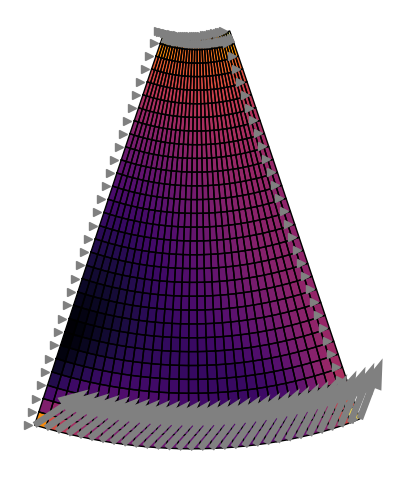

In [11]:
# Create and plot the domain
wheel = Planar(
    nodes, elements, forces, displacements, constraints, thickness, C=material.C()
)

# Solve the system
u, f = wheel.solve()

# Compute von Mises stress
mises = wheel.compute_stress(u, mises=True)

# Plot the initial result
wheel.plot(u=u, element_property=mises, cmap="inferno")

In [12]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5 * torch.ones(len(wheel.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume
vols = compute_areas(item = wheel)
V0 = volume_constraint * vols.sum()

100%|██████████| 100/100 [00:01<00:00, 61.26it/s]


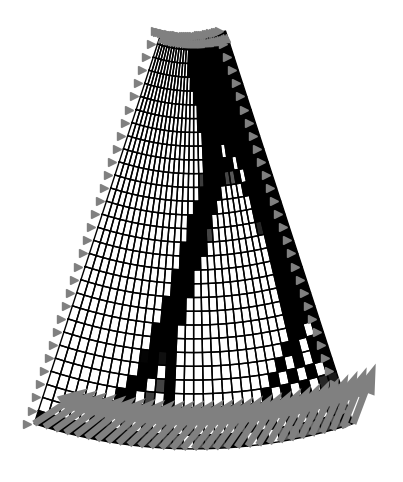

In [13]:
# Optimize and visualize results without filter radius
d_opt, compliance = optimize(wheel, rho_0, rho_min, rho_max, V_0 = V0, r = 0.0)
wheel.plot(element_property=d_opt[-1], cmap="gray_r")

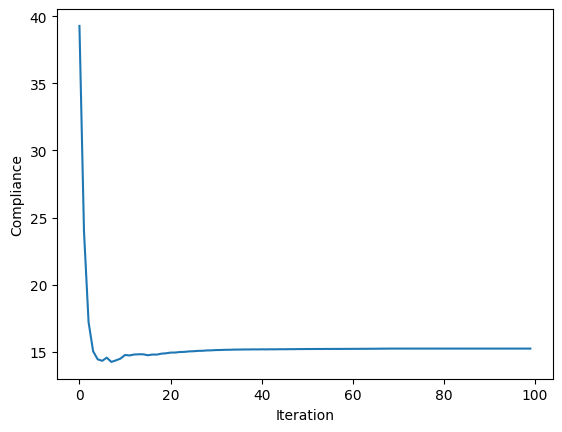

In [14]:
# plt.plot(torch.stack(d_opt).detach())
# plt.xlabel("Iteration")
# plt.ylabel("Values $d_i$")
# plt.grid()

plt.figure()
plt.plot(compliance)
plt.xlabel('Iteration')
plt.ylabel('Compliance')
plt.show()

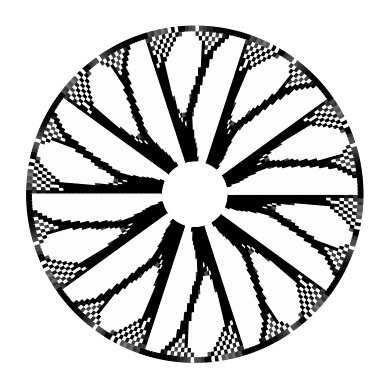

In [15]:
# Plot optimized wheel
plot_wheel(wheel, d_opt[-1])

100%|██████████| 100/100 [00:01<00:00, 63.97it/s]


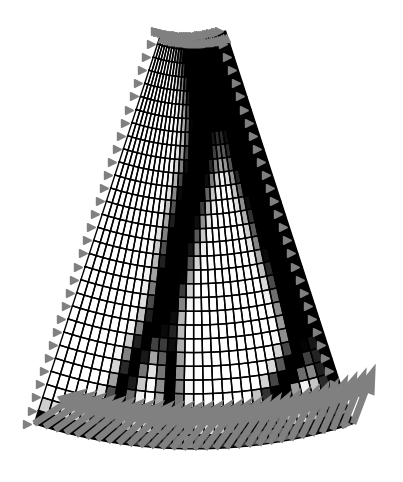

In [16]:
# Optimize and visualize results with filter radius
d_opt, compliance = optimize(wheel, rho_0, rho_min, rho_max, V_0 = V0)
wheel.plot(element_property=d_opt[-1], cmap="gray_r")

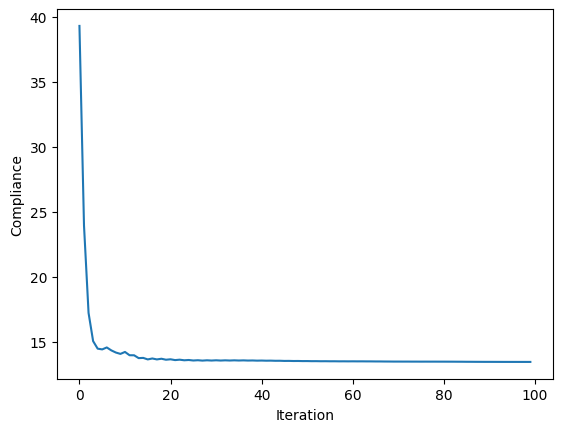

In [17]:
# plt.plot(torch.stack(d_opt).detach())
# plt.xlabel("Iteration")
# plt.ylabel("Values $d_i$")
# plt.grid()

plt.figure()
plt.plot(compliance)
plt.xlabel('Iteration')
plt.ylabel('Compliance')
plt.show()

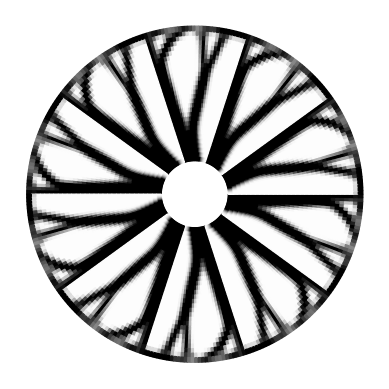

In [18]:
# Plot optimized wheel
plot_wheel(wheel, d_opt[-1])